In [134]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# from tflite_model_maker import model_spec
# from tflite_model_maker import image_classifier
# from tflite_model_maker.config import ExportFormat
# from tflite_model_maker.config import QuantizationConfig
# from tflite_model_maker.image_classifier import DataLoader
# import sys
# sys.modules[__name__].__dict__.clear()


In [136]:
# data=DataLoader.from_folder("/nfs/general/shared/")
# train_data, rest_data = data.split(0.8)


aside=np.array([mpimg.imread(x) for x in glob.glob('/nfs/general/shared/KeyA/*.jpg')])
bside=np.array([mpimg.imread(x) for x in glob.glob('/nfs/general/shared/KeyD/*.jpg')])

def ExtractRoi(img):   
    img=tf.cast(img[220:320, 260:400, :], tf.float32)-150
    return tf.cast(tf.maximum(img, tf.zeros_like(img))+150, tf.uint8)


# ExtractRoi(aside[0,:,:,:])

In [137]:
from sklearn.cluster import KMeans

# X = np.concatenate((
#     aside.reshape((-1, 3)),
#     bside.reshape((-1, 3))))

X=tf.vectorized_map(ExtractRoi, tf.concat((aside,bside), axis=0))
X=tf.reshape(X, (-1,3)).numpy()
kmeans = KMeans(n_clusters=32, random_state=0, verbose=0, max_iter=300, n_init=10).fit(X)


Initialization complete
Iteration 0, inertia 172292376.0
Iteration 1, inertia 141452082.15156552
Iteration 2, inertia 136002773.25732255
Iteration 3, inertia 134275700.9177131
Iteration 4, inertia 133370906.61924985
Iteration 5, inertia 132656818.62299317
Iteration 6, inertia 131973175.99431372
Iteration 7, inertia 131314985.94309798
Iteration 8, inertia 130776604.57941426
Iteration 9, inertia 130388529.66017279
Iteration 10, inertia 130128302.71846129
Iteration 11, inertia 129924625.95903847
Iteration 12, inertia 129740630.34094606
Iteration 13, inertia 129569425.48317711
Iteration 14, inertia 129400151.58538106
Iteration 15, inertia 129247496.52485384
Iteration 16, inertia 129109417.59971024
Iteration 17, inertia 128981884.8633993
Iteration 18, inertia 128857379.24794333
Iteration 19, inertia 128731234.5115818
Iteration 20, inertia 128590586.97260973
Iteration 21, inertia 128455024.71683744
Iteration 22, inertia 128294533.37184834
Iteration 23, inertia 128123979.19345425
Iteration 24

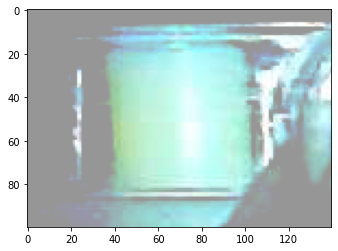

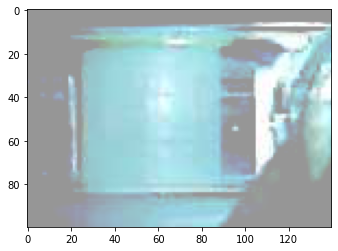

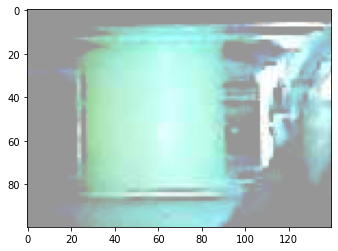

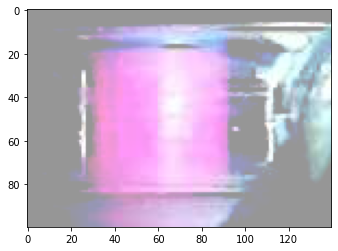

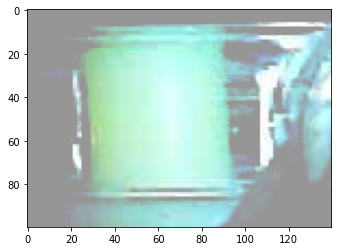

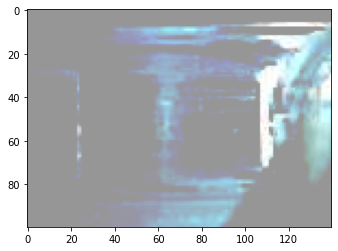

In [130]:
centroids = tf.constant(kmeans.cluster_centers_, dtype=tf.float32)


class Quantizer(tf.Module):
    def QuantizeImagePixels(self, sample_image):
        sample_image = ExtractRoi(sample_image)
        sample_image_as_vec = tf.cast(
            tf.reshape(sample_image, (-1, 3)), tf.float32)
        cov_mat = -2.0*tf.matmul(sample_image_as_vec,
                                 centroids, transpose_a=False, transpose_b=True)
        labels = tf.argmin(cov_mat + tf.reduce_sum(sample_image_as_vec*sample_image_as_vec,
                           1, keepdims=True) + tf.reduce_sum(centroids*centroids, 1), axis=1)
        return tf.reshape(labels, sample_image.shape[:2])

    #
    def QuantizeHist(self, sample_image):
        sample_image = ExtractRoi(sample_image)
        sample_image_as_vec = tf.cast(
            tf.reshape(sample_image, (-1, 3)), tf.float32)
        cov_mat = -2.0*tf.matmul(sample_image_as_vec,
                                 centroids, transpose_a=False, transpose_b=True)
        labels = tf.argmin(cov_mat + tf.reduce_sum(sample_image_as_vec*sample_image_as_vec,
                           1, keepdims=True) + tf.reduce_sum(centroids*centroids, 1), axis=1)
        return tf.reduce_sum(tf.one_hot(labels, centroids.shape[0]), axis=0)


m = Quantizer()

for i in [2,3,4]:
    plt.imshow(ExtractRoi(aside[i, :, :, :]))
    plt.show()
    plt.imshow(ExtractRoi(bside[i, :, :, :]))
    plt.show()


In [133]:
# from sklearn.decomposition import PCA
# foo=PCA(n_components=5).fit_transform(tf.concat((a_quantized,b_quantized),axis=0).numpy())
# plt.scatter(foo[:,0],foo[:,1],color='r')

# plt.scatter(foo[:a_quantized.shape[0],0],foo[:a_quantized.shape[0],1],color='g')

a_quantized=tf.vectorized_map(m.QuantizeHist, aside)
b_quantized=tf.vectorized_map(m.QuantizeHist, bside)


model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

X=tf.concat((a_quantized,b_quantized),axis=0)

y=tf.concat((tf.zeros((a_quantized.shape[0],)),tf.ones((b_quantized.shape[0],))),axis=0)
model.fit(X, y, epochs=50)
# fashion_mnist = tf.keras.datasets.fashion_mnist

# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])



# 


Epoch 1/50
4/4 [==============================] - 0s 829us/step - loss: 673.1854 - accuracy: 0.1930
Epoch 2/50
4/4 [==============================] - 0s 643us/step - loss: 418.9536 - accuracy: 0.2105
Epoch 3/50
4/4 [==============================] - 0s 960us/step - loss: 201.8121 - accuracy: 0.3947
Epoch 4/50
4/4 [==============================] - 0s 646us/step - loss: 50.4124 - accuracy: 0.6228
Epoch 5/50
4/4 [==============================] - 0s 686us/step - loss: 48.1040 - accuracy: 0.7807
Epoch 6/50
4/4 [==============================] - 0s 813us/step - loss: 52.6138 - accuracy: 0.8158
Epoch 7/50
4/4 [==============================] - 0s 1ms/step - loss: 50.4544 - accuracy: 0.8158
Epoch 8/50
4/4 [==============================] - 0s 883us/step - loss: 39.5941 - accuracy: 0.8158
Epoch 9/50
4/4 [==============================] - 0s 905us/step - loss: 25.1872 - accuracy: 0.8421
Epoch 10/50
4/4 [==============================] - 0s 1ms/step - loss: 14.8930 - accuracy: 0.8947
Epoch 11/5

array([[1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [9.9999881e-01, 1.1481377e-06],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.

In [3]:
class ImageClassifier(tf.Module):
    def __init__(self):
        self.quantizer = Quantizer()
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[480, 640, 3], dtype=tf.uint8)])
    def Classify(self, sample_image):
        return probability_model.predict(sample_image)




model = ImageClassifier()


tf.saved_model.save(model, '/tmp/classifier')
converter = tf.lite.TFLiteConverter.from_saved_model('/tmp/classifier') # path to the SavedModel directory
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
#   tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()
open('/nfs/general/shared/adder.tflite', 'wb').write(tflite_model)


# model_spec.IMAGE_CLASSIFICATION_MODELS
# spec=model_spec.get('efficientnet_lite4')

# spec.input_image_shape

[300, 300]

In [4]:
validation_data, test_data = rest_data.split(0.5)
model = image_classifier.create(train_data, model_spec=model_spec.get('efficientnet_lite4'), validation_data=validation_data, epochs = 20)


INFO:tensorflow:Retraining the models...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             11837936  
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 11,840,498
Trainable params: 2,562
Non-trainable params: 11,837,936
_________________________________________________________________
None
Epoch 1/20


/home/geli/.local/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


2/2 [==============================] - 4s 2s/step - loss: 0.6383 - accuracy: 0.6250 - val_loss: 0.5008 - val_accuracy: 0.8182
Epoch 2/20
2/2 [==============================] - 2s 1s/step - loss: 0.5673 - accuracy: 0.7969 - val_loss: 0.5598 - val_accuracy: 0.8182
Epoch 3/20
2/2 [==============================] - 2s 1s/step - loss: 0.6280 - accuracy: 0.7969 - val_loss: 0.4920 - val_accuracy: 0.8182
Epoch 4/20
2/2 [==============================] - 2s 1s/step - loss: 0.5575 - accuracy: 0.7812 - val_loss: 0.5371 - val_accuracy: 0.7273
Epoch 5/20
2/2 [==============================] - 2s 1s/step - loss: 0.5692 - accuracy: 0.6875 - val_loss: 0.5453 - val_accuracy: 0.7273
Epoch 6/20
2/2 [==============================] - 2s 1s/step - loss: 0.5413 - accuracy: 0.7812 - val_loss: 0.4574 - val_accuracy: 0.8182
Epoch 7/20
2/2 [==============================] - 2s 1s/step - loss: 0.5508 - accuracy: 0.7969 - val_loss: 0.4789 - val_accuracy: 0.8182
Epoch 8/20
2/2 [==============================] - 2s

In [5]:
loss, accuracy = model.evaluate(test_data)


model.export(export_dir='/nfs/general/shared')

1/1 [==============================] - 0s 336ms/step - loss: 0.4282 - accuracy: 0.9167


2022-04-16 15:44:18.133302: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmph8vqweyc/assets


INFO:tensorflow:Assets written to: /tmp/tmph8vqweyc/assets
2022-04-16 15:44:23.333775: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-04-16 15:44:23.333869: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-04-16 15:44:23.379252: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1164] Optimization results for grappler item: graph_to_optimize
  function_optimizer: Graph size after: 1683 nodes (1216), 1707 edges (1238), time = 25.218ms.
  function_optimizer: function_optimizer did nothing. time = 0.01ms.

/home/geli/.local/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-04-16 15:44:24.373808: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_forma

INFO:tensorflow:Label file is inside the TFLite model with metadata.


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3
INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmppqwxcy75/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmppqwxcy75/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: /nfs/general/shared/model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: /nfs/general/shared/model.tflite


In [7]:
class Adder(tf.Module):
  @tf.function(input_signature=[tf.TensorSpec(shape=[480,640], dtype=tf.uint8)])
  def add(self, image):
    image = image[tf.newaxis, ..., tf.newaxis]
    return image

model = Adder()
tf.saved_model.save(model, '/tmp/adder')


converter = tf.lite.TFLiteConverter.from_saved_model('/tmp/adder') # path to the SavedModel directory
tflite_model = converter.convert()

with open('/nfs/general/shared/adder.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/adder/assets


INFO:tensorflow:Assets written to: /tmp/adder/assets
2022-04-16 15:17:41.245018: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-04-16 15:17:41.245037: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


Estimated count of arithmetic ops: 0  ops, equivalently 0  MACs


2022-04-16 15:17:41.245221: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/adder
2022-04-16 15:17:41.245395: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-04-16 15:17:41.245403: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/adder
2022-04-16 15:17:41.245820: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-04-16 15:17:41.254473: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/adder
2022-04-16 15:17:41.257203: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 11982 microseconds.
2022-04-16 15:17:41.268568: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:1963] Estimated count of arithmetic ops: 0  ops, equivalently 0  MACs

